# Initialize and copy data zip

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls '/gdrive/MyDrive/MemesDeepLearning'

'4803 Project Proposal.gdoc'	     mmbt_model_best.zip
 CLIPBaselineipynb.ipynb	     MMBT_training.ipynb
 computed_data			     mmbt.zip
 computed_trainset.zip		    'MMF Tutorial.ipynb'
 computed_valset		     model_weights
 computed_valset.zip		     NeuralNetworkMeme.ipynb
'Copy of ToxicityAnalysis.ipynb'     preprocessed_data
'Data Efficiency.gdoc'		     pretrained_models_for_image_preprocessing
 dataFB.zip			     tensorDataPreprocessed.zip
 dev_all.jsonl			     tensorDataTestOnly.zip
'DialoGPT2 (Unimodal).ipynb'	     tensorData.zip
 final_model_submission.gsheet	     test.jsonl
'Generate Clean Meme Images.ipynb'   test_unseen.jsonl
'GPT (Unimodal).ipynb'		     ToxicityAnalysis.ipynb
 IterateMemes.ipynb		    'Untitled document.gdoc'
 mmbt_checkpoints.zip		    'VisualBERT + CLIP.ipynb'
 MMBT_inference.ipynb		     VisualGPT.ipynb


In [ ]:
!cp '/gdrive/MyDrive/MemesDeepLearning/dataFB.zip' '/content/data.zip'

In [ ]:
!cp '/gdrive/MyDrive/MemesDeepLearning/preprocessed_data/img_clean.zip' '/content/img_clean.zip'

In [ ]:
!unzip -q data.zip
!unzip -q img_clean.zip
!mv img_clean img

# Scan train.jsonl

In [ ]:
!pwd

/content


In [ ]:
import json

result = [json.loads(jline) for jline in open('data/train.jsonl', 'r')]
resultDev = [json.loads(jline) for jline in open('data/dev_seen.jsonl', 'r')]
resultTest = [json.loads(jline) for jline in open('test.jsonl', 'r')]
#print(len(resultTrain))
print(len(result))
print(len(resultDev))
result = resultDev

8500
500


{'id': '16395', 'img': 'img/16395.png', 'label': 1, 'text': 'handjobs sold seperately'}


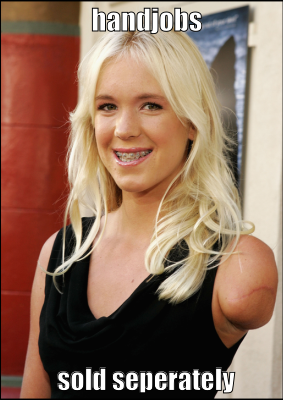

In [ ]:
index = 0

from IPython.display import Image
print(result[index])
#print('/gdrive/MyDrive/data/'+result[index]['img'])
#if result[index]['label'] is 0:
#  print("Good meme:")
#else:
#  print("Hateful meme:")
display(Image('data/'+result[index]['img']))

In [ ]:
tot = 0
for i in range(len(result)):
  tot += result[i]['label']
print(tot/len(result))
print(1-tot/len(result))

0.49
0.51


# CLIP portions below

In [ ]:
while True:
  pass

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",    
}
!wget {MODELS["ViT-B/32"]} -O model.pt
!wget https://openaipublic.azureedge.net/clip/bpe_simple_vocab_16e6.txt.gz -O bpe_simple_vocab_16e6.txt.gz

In [ ]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

model = torch.jit.load("model.pt").cuda().eval()
input_resolution = model.input_resolution.item()
context_length = model.context_length.item()
vocab_size = model.vocab_size.item()

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)


from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image

preprocess = Compose([
    Resize(input_resolution, interpolation=Image.BICUBIC),
    CenterCrop(input_resolution),
    ToTensor()
])

image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).cuda()
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).cuda()

!pip install ftfy regex

Torch version: 1.7.1+cu110
Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


Remember to run this code too:

In [ ]:
#@title

import gzip
import html
import os
from functools import lru_cache

import ftfy
import regex as re


@lru_cache()
def bytes_to_unicode():
    """
    Returns list of utf-8 byte and a corresponding list of unicode strings.
    The reversible bpe codes work on unicode strings.
    This means you need a large # of unicode characters in your vocab if you want to avoid UNKs.
    When you're at something like a 10B token dataset you end up needing around 5K for decent coverage.
    This is a signficant percentage of your normal, say, 32K bpe vocab.
    To avoid that, we want lookup tables between utf-8 bytes and unicode strings.
    And avoids mapping to whitespace/control characters the bpe code barfs on.
    """
    bs = list(range(ord("!"), ord("~")+1))+list(range(ord("¡"), ord("¬")+1))+list(range(ord("®"), ord("ÿ")+1))
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8+n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs))


def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def basic_clean(text):
    text = ftfy.fix_text(text)
    text = html.unescape(html.unescape(text))
    return text.strip()


def whitespace_clean(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text


class SimpleTokenizer(object):
    def __init__(self, bpe_path: str = "bpe_simple_vocab_16e6.txt.gz"):
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        merges = gzip.open(bpe_path).read().decode("utf-8").split('\n')
        merges = merges[1:49152-256-2+1]
        merges = [tuple(merge.split()) for merge in merges]
        vocab = list(bytes_to_unicode().values())
        vocab = vocab + [v+'</w>' for v in vocab]
        for merge in merges:
            vocab.append(''.join(merge))
        vocab.extend(['<|startoftext|>', '<|endoftext|>'])
        self.encoder = dict(zip(vocab, range(len(vocab))))
        self.decoder = {v: k for k, v in self.encoder.items()}
        self.bpe_ranks = dict(zip(merges, range(len(merges))))
        self.cache = {'<|startoftext|>': '<|startoftext|>', '<|endoftext|>': '<|endoftext|>'}
        self.pat = re.compile(r"""<\|startoftext\|>|<\|endoftext\|>|'s|'t|'re|'ve|'m|'ll|'d|[\p{L}]+|[\p{N}]|[^\s\p{L}\p{N}]+""", re.IGNORECASE)

    def bpe(self, token):
        if token in self.cache:
            return self.cache[token]
        word = tuple(token[:-1]) + ( token[-1] + '</w>',)
        pairs = get_pairs(word)

        if not pairs:
            return token+'</w>'

        while True:
            bigram = min(pairs, key = lambda pair: self.bpe_ranks.get(pair, float('inf')))
            if bigram not in self.bpe_ranks:
                break
            first, second = bigram
            new_word = []
            i = 0
            while i < len(word):
                try:
                    j = word.index(first, i)
                    new_word.extend(word[i:j])
                    i = j
                except:
                    new_word.extend(word[i:])
                    break

                if word[i] == first and i < len(word)-1 and word[i+1] == second:
                    new_word.append(first+second)
                    i += 2
                else:
                    new_word.append(word[i])
                    i += 1
            new_word = tuple(new_word)
            word = new_word
            if len(word) == 1:
                break
            else:
                pairs = get_pairs(word)
        word = ' '.join(word)
        self.cache[token] = word
        return word

    def encode(self, text):
        bpe_tokens = []
        text = whitespace_clean(basic_clean(text)).lower()
        for token in re.findall(self.pat, text):
            token = ''.join(self.byte_encoder[b] for b in token.encode('utf-8'))
            bpe_tokens.extend(self.encoder[bpe_token] for bpe_token in self.bpe(token).split(' '))
        return bpe_tokens

    def decode(self, tokens):
        text = ''.join([self.decoder[token] for token in tokens])
        text = bytearray([self.byte_decoder[c] for c in text]).decode('utf-8', errors="replace").replace('</w>', ' ')
        return text


# Run code below as well

In [ ]:
result = resultDev

In [ ]:
!mkdir newData

In [ ]:
!rm newData/dev*

ratio groundTruth that is hateful: 0.494
Accuracy is: 0.544
AUROC is: 0.5675217231281304


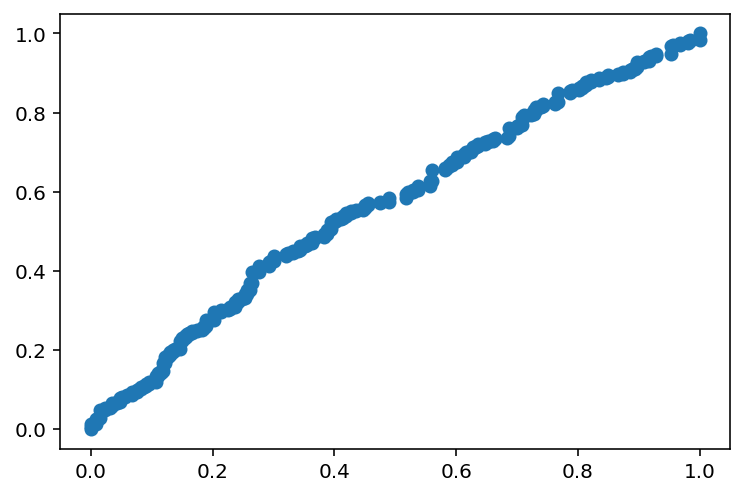

In [ ]:

for indiv in range(0,1): #set to range(0,8) to export embeddings
  #Change as necessary
  showImages = False
  storeTruth = True
  storeAnything = False
  oldStyle = True #checks similarity of descriptions, ignores text
  useCleanImages = False #uses preprocessed images

  descriptions = {
      'good meme': 'a nonhateful meme that is good',
      'hateful meme': 'a hateful meme containing racism or sexism'
  }
  indexes = None
  if oldStyle:
    indexes = range(len(result))
  else:
    indexes = range((indiv)*(len(result)//8),(indiv+1)*(len(result)//8))
  import os
  import skimage
  import IPython.display
  import matplotlib.pyplot as plt
  from PIL import Image
  import numpy as np
  from scipy.special import softmax
  from sklearn import metrics
  import sklearn
  from collections import OrderedDict
  import torch

  %matplotlib inline
  %config InlineBackend.figure_format = 'retina'
  images = []

  texts = []
  if oldStyle:
      texts = [descriptions['good meme'],descriptions['hateful meme']]
 

  
  groundTruth = np.zeros(len(indexes),dtype=np.uint8)

  if showImages:
    plt.figure(figsize=(16, 16))


  #'data/'+result[index]['img']
  i = 0
  for index in indexes:
      if useCleanImages:
        filepath = result[index]['img']
      else:
        filepath = 'data/'+result[index]['img']
      #
      if storeTruth:
        name = "good meme" if result[index]['label']==0 else "hateful meme"
        groundTruth[i] = result[index]['label']
      i+=1
      image = preprocess(Image.open(filepath).convert("RGB"))
      images.append(image)
      if not oldStyle:
        texts.append(result[index]['text'])
      #texts.append(descriptions[name])
      if showImages:
        plt.subplot(5, 2, len(images))
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"{filepath} – {result[index]['text']}\n{descriptions[name]}")
        plt.xticks([])
        plt.yticks([])
  if showImages:
    plt.tight_layout()

  image_input = torch.tensor(np.stack(images)).cuda()
  image_input -= image_mean[:, None, None]
  image_input /= image_std[:, None, None]
  tokenizer = SimpleTokenizer()
  text_tokens = [tokenizer.encode(desc) for desc in texts]
  text_input = torch.zeros(len(text_tokens), model.context_length, dtype=torch.long)
  sot_token = tokenizer.encoder['<|startoftext|>']
  eot_token = tokenizer.encoder['<|endoftext|>']

  for i, tokens in enumerate(text_tokens):
      tokens = tokens[0:73]
      tokens = [sot_token] + tokens + [eot_token]
      text_input[i, :len(tokens)] = torch.tensor(tokens)

  text_input = text_input.cuda()
  with torch.no_grad():
      image_features = model.encode_image(image_input).float()
      text_features = model.encode_text(text_input).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
  if showImages:
    count = len(descriptions)

    plt.figure(figsize=(20, 5))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    plt.yticks(range(count), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(images):
        plt.imshow(image.permute(1, 2, 0), extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title("Cosine similarity between text and image features", size=20)


  simMax = np.argmax(similarity, axis=0)
  #print(similarity)
  #print(simMax)
  #print(groundTruth)
  if storeTruth:
    print(f"ratio groundTruth that is hateful: {np.sum(groundTruth)/groundTruth.shape[0]}")
    print(f"Accuracy is: {np.sum(simMax==groundTruth)/groundTruth.shape[0]}")
    similarity = np.transpose(similarity)
    second = softmax(similarity,axis=1)
    #print(second)
    #print(second[0])
    fpr, tpr, thresholds = metrics.roc_curve(groundTruth, second[:,1], pos_label=1)
    auroc = metrics.auc(tpr, fpr)
    plt.scatter(fpr,tpr)
    print(f"AUROC is: {sklearn.metrics.roc_auc_score(groundTruth, second[:,1])}")
  if storeAnything:
    torch.save(image_features, f'newData/dev_img_{indiv}.pt')
    torch.save(text_features, f'newData/dev_txt_{indiv}.pt')
    if storeTruth:
      torch.save(groundTruth, f'newData/dev_truth_{indiv}.pt')

In [ ]:
#import torch
testLoad = torch.load('newData/dev_img_2.pt')

In [ ]:
!zip tensorDataPreprocessed.zip newData/*

  adding: newData/dev_img_0.pt (deflated 11%)
  adding: newData/dev_img_1.pt (deflated 11%)
  adding: newData/dev_img_2.pt (deflated 11%)
  adding: newData/dev_img_3.pt (deflated 11%)
  adding: newData/dev_img_4.pt (deflated 11%)
  adding: newData/dev_img_5.pt (deflated 12%)
  adding: newData/dev_img_6.pt (deflated 11%)
  adding: newData/dev_img_7.pt (deflated 11%)
  adding: newData/dev_truth_0.pt (deflated 51%)
  adding: newData/dev_truth_1.pt (deflated 50%)
  adding: newData/dev_truth_2.pt (deflated 49%)
  adding: newData/dev_truth_3.pt (deflated 49%)
  adding: newData/dev_truth_4.pt (deflated 49%)
  adding: newData/dev_truth_5.pt (deflated 50%)
  adding: newData/dev_truth_6.pt (deflated 50%)
  adding: newData/dev_truth_7.pt (deflated 49%)
  adding: newData/dev_txt_0.pt (deflated 11%)
  adding: newData/dev_txt_1.pt (deflated 13%)
  adding: newData/dev_txt_2.pt (deflated 11%)
  adding: newData/dev_txt_3.pt (deflated 11%)
  adding: newData/dev_txt_4.pt (deflated 13%)
  adding: newData/

In [ ]:
print(testLoad.shape)

NameError: ignored

In [ ]:
!ls

bpe_simple_vocab_16e6.txt.gz  data.zip	model.pt  sample_data
data			      __MACOSX	newData   test_1.zip


In [ ]:
print(image_features.shape)

tensor([[ 0.0204, -0.0221, -0.0052,  ...,  0.0055,  0.0035,  0.0004],
        [ 0.0459, -0.0105, -0.0203,  ..., -0.0194,  0.0468, -0.0172],
        [ 0.0079, -0.0483, -0.0113,  ...,  0.0077,  0.0051, -0.0118],
        ...,
        [ 0.0028,  0.0220,  0.0424,  ...,  0.0492, -0.0025, -0.0325],
        [-0.0016,  0.0048, -0.0407,  ..., -0.0090, -0.0104,  0.0062],
        [-0.0346, -0.0155,  0.0102,  ...,  0.0425,  0.0023,  0.0023]],
       device='cuda:0')


In [ ]:
getData()

In [ ]:
!ls -lh tensorData.zip

-rw-r--r-- 1 root root 32M Apr 25 21:54 tensorData.zip


#todo add a neural network here or somethin

Initialize model

In [ ]:
import torch.nn as nn
class MainModel(nn.Module):
    def __init__(self):
        super(MainModel, self).__init__()
        self.Linear1 = nn.Linear(1024,50)
        self.Linear2 = nn.Linear(50,2)

    def forward(self, x):
        x = self.Linear1(x)
        x = self.Linear2(x)
        return x

In [ ]:
model = MainModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)